In [1]:
import torch
from CSP_training import *
import matplotlib.pyplot as plt

In [9]:
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

download_dataset()
walk_through_dir(image_path)


# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"


# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    transforms.RandomRotation(degrees=0.2),
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])
# Use ImageFolder to create dataset(s)

train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

CSP = CSPDarknet(3, 16).to(device)

img_batch, label_batch = next(iter(train_dataloader))
img_single, label_single = img_batch[0].unsqueeze(dim=0).to(device), label_batch[0]

CSP.eval()
with torch.inference_mode():
    pred = CSP(img_single)
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

NUM_EPOCHS = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=CSP.parameters(), lr=0.001)

res = train(model=CSP, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
           optimizer=optimizer,
           loss_fn=loss_fn,
           epochs=NUM_EPOCHS)

data/pizza_steak_sushi directory exists.
There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.4547 | train_acc: 0.3244 | test_loss: 1.2053 | test_acc: 0.4000
Epoch: 2 | train_loss: 1.2158 | train_acc: 0.4178 | test_loss: 1.6588 | test_acc: 0.3600
Epoch: 3 | train_loss: 1.1661 | train_acc: 0.4578 | test_loss: 2.3573 | test_acc: 0.3067
Epoch: 4 | train_loss: 1.1934 | train_acc: 0.3911 | test_loss: 1.3538 | test_acc: 0.3467
Epoch: 5 | train_loss: 1.0368 | train_acc: 0.5244 | test_loss: 1.3968 | test_acc: 0.4533
Epoch: 6 | train_loss: 1.1052 | train_acc: 0.4533 | test_loss: 1.1445 | test_acc: 0.4400
Epoch: 7 | train_loss: 1.0414 | train_acc: 0.5467 | test_loss: 1.7375 | test_acc: 0.3600
Epoch: 8 | train_loss: 1.0754 | train_acc: 0.4844 | test_loss: 1.5877 | test_acc: 0.2933
Epoch: 9 | train_loss: 1.1204 | train_acc: 0.4667 | test_loss: 1.6963 | test_acc: 0.4133
Epoch: 10 | train_loss: 1.0297 | train_acc: 0.5022 | test_loss: 1.0506 | test_acc: 0.4400
Epoch: 11 | train_loss: 1.0892 | train_acc: 0.4933 | test_loss: 1.0229 | test_acc: 0.4400
Epoch: 12 | train_l

In [3]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

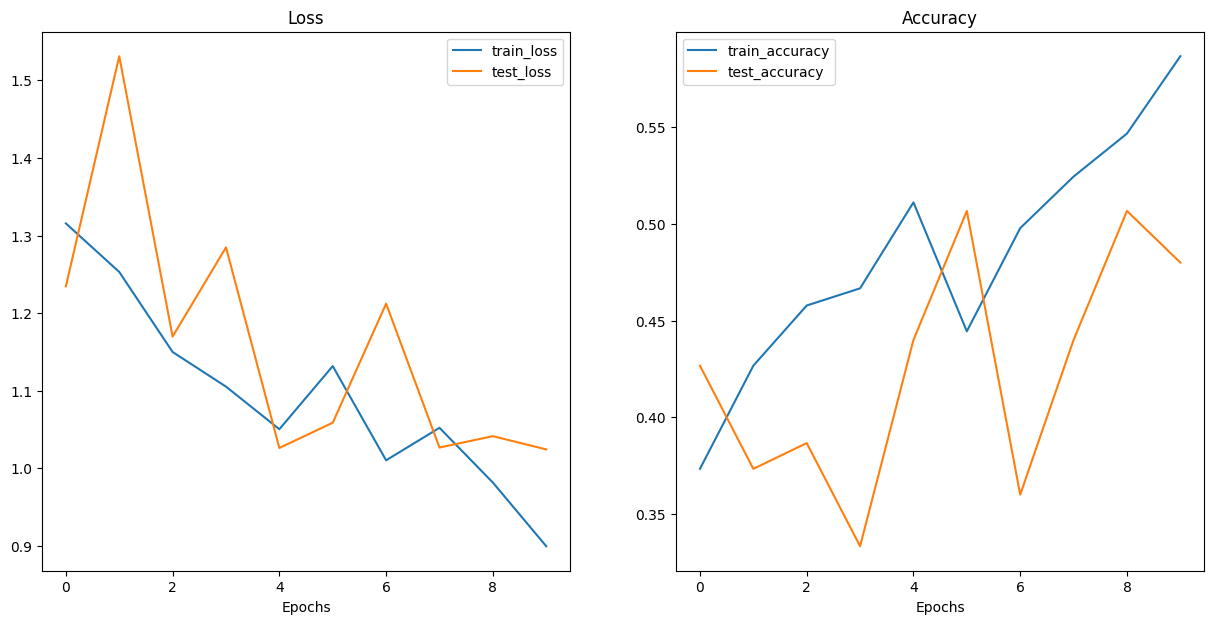

In [4]:
plot_loss_curves(res)